# Natural Language Processing First Assignment
#### This is the notebook for the first assignment about the dataset **"Polite Guard"**. The objective of this work is to come up with a pipeline that builds a robust and good model for text classification
#### The following dependencies are needed:
`
pip install datasets pandas nltk scikit-learn wordcloud matplotlib
`

## **Importing the dataset**
##### The first step is to import the dataset we are using, directly from the library provided by Hugging Face. The original dataset already split test and training data, as well as validation data.

In [2]:
import pandas as pd;
from datasets import load_dataset

dataset = load_dataset("Intel/polite-guard");
print(dataset);

traning_set = pd.DataFrame.from_dict(dataset['train']);
test_set = pd.DataFrame.from_dict(dataset['test']);
validation_set = pd.DataFrame.from_dict(dataset['validation']);

print(traning_set.head());
print(test_set.head());
print(validation_set.head());

/home/joca/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'source', 'reasoning'],
        num_rows: 80000
    })
    validation: Dataset({
        features: ['text', 'label', 'source', 'reasoning'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label', 'source', 'reasoning'],
        num_rows: 10200
    })
})
                                                text            label  \
0  Your flight has been rescheduled for 10:00 AM ...          neutral   
1  We're happy to accommodate your dietary prefer...           polite   
2  Our vegetarian options are available on the me...          neutral   
3  I understand your frustration with the recent ...  somewhat polite   
4  I'll do my best to find a suitable replacement...  somewhat polite   

                                  source  \
0  meta-llama/Meta-Llama-3.1-8B-Instruct   
1  meta-llama/Meta-Llama-3.1-8B-Instruct   
2  meta-llama/Meta-Llama-3.1-8B-Instruct   
3  meta-llama/Meta-Llama-3.1

##### The text corpuses are mainly about different types of language in terms of formality, the label to be classified is if the corpus is a polite or impolite. **There are 4 classes which are "impolite" , "neutral" , "somewhat polite" and "polite"**
##### There are four features of the dataset which are:
- ##### **text** - actual text corpus;
- ##### **label** - class label to identify text formality;
- ##### **reasoning** - why it was labeled as that class;
- ##### **source** - source of the text;
##### The majority of the dataset were **result of prompting using different synthesis techniques**, including only 200 annotated real-life examples from corporate training.
##### The prompting techniques used: 
- ##### 50,000 samples generated using Few-Shot prompting
- ##### 50,000 samples generated using Chain-of-Thought (CoT) prompting
- ##### 200 annotated samples from corporate trainings; 
##### The test/train/validation split was done as follows:
- ##### **80k rows for training**;
- ##### **20k rows for testing**;
- ##### **remaining rows for validation (200 annotated samples)**;

## **Check the Basics**
### Let's just check some basic attributes in EDA for our dataset.

In [3]:
traning_set.isnull().sum()

text             0
label            0
source           0
reasoning    40001
dtype: int64

##### The reasoning label has some NaN values, but we can just ignore that column at all for our task.

## **Extracting text corpus**
##### We have to extract the text from the documents in te dataset so we can use different representations to operate on.
##### Note that this is an unclean version of the corpus

In [4]:
unclean_corpus = []
for i in range(0, len(traning_set["text"])):
    unclean_corpus.append(traning_set['text'][i]);
print(unclean_corpus[0:5]);

["Your flight has been rescheduled for 10:00 AM tomorrow. Please check the airport's website for any updates or changes.", "We're happy to accommodate your dietary preferences. Our vegetarian options are carefully crafted to ensure a delicious and satisfying meal. Would you like me to recommend some dishes that fit your needs?", 'Our vegetarian options are available on the menu, and our chef can modify any dish to suit your dietary needs.', "I understand your frustration with the recent tournament results, and I'll review the standings to see what we can do to improve your experience.", "I'll do my best to find a suitable replacement for the item you're looking for, but I need to know more about what you're looking for."]


## **Cleaning the text corpus**
##### Now we need to process the unclean text corpus, by performing actions such as:
- ##### Removing punctuation;
- ##### Lower case folding;
- ##### Stemming (using PorterStemmer);
- ##### Removing Stop Words (optional);
##### For that effect we will import [regular expression](https://docs.python.org/3/library/re.html) library and [nltk](https://www.nltk.org/api/nltk.html)

In [5]:
import nltk;
nltk.download('stopwords')
import re;
from nltk.corpus import stopwords;
from nltk.stem.porter import PorterStemmer;

ps = PorterStemmer();
sw = stopwords.words('english');
clean_corpus = []
for i in range(0,len(unclean_corpus)):
    text = re.sub('[^a-zA-Z]', ' ', unclean_corpus[i]);
    text = text.lower();

    text = [ps.stem(word) for word in text.split() if not word in sw];
    text = ' '.join(text);
    clean_corpus.append(text);
print(clean_corpus[0:5]);

[nltk_data] Downloading package stopwords to /home/joca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['flight reschedul tomorrow pleas check airport websit updat chang', 'happi accommod dietari prefer vegetarian option care craft ensur delici satisfi meal would like recommend dish fit need', 'vegetarian option avail menu chef modifi dish suit dietari need', 'understand frustrat recent tournament result review stand see improv experi', 'best find suitabl replac item look need know look']


##### As we now have our corpus, before and after pre-processing, we can proceed to the exploratory data analysis with both corpus.

In [6]:
traning_set['clean_text'] = clean_corpus;
traning_set['unclean_text'] = unclean_corpus;

print(traning_set.head());

                                                text            label  \
0  Your flight has been rescheduled for 10:00 AM ...          neutral   
1  We're happy to accommodate your dietary prefer...           polite   
2  Our vegetarian options are available on the me...          neutral   
3  I understand your frustration with the recent ...  somewhat polite   
4  I'll do my best to find a suitable replacement...  somewhat polite   

                                  source  \
0  meta-llama/Meta-Llama-3.1-8B-Instruct   
1  meta-llama/Meta-Llama-3.1-8B-Instruct   
2  meta-llama/Meta-Llama-3.1-8B-Instruct   
3  meta-llama/Meta-Llama-3.1-8B-Instruct   
4  meta-llama/Meta-Llama-3.1-8B-Instruct   

                                           reasoning  \
0  This text would be classified as "neutral" bec...   
1  This text is polite because it expresses grati...   
2  This text would be classified as "neutral" bec...   
3  This text would be classified as "somewhat pol...   
4  This text wou

### Class Distribution

##### Firstly, let's start by analysing how much classes we have and how well those classes are distributed.

In [7]:
print(traning_set['label'].nunique());

4


Amount of each class in the training set:
label
neutral            20000
polite             20000
somewhat polite    20000
impolite           20000
Name: count, dtype: int64


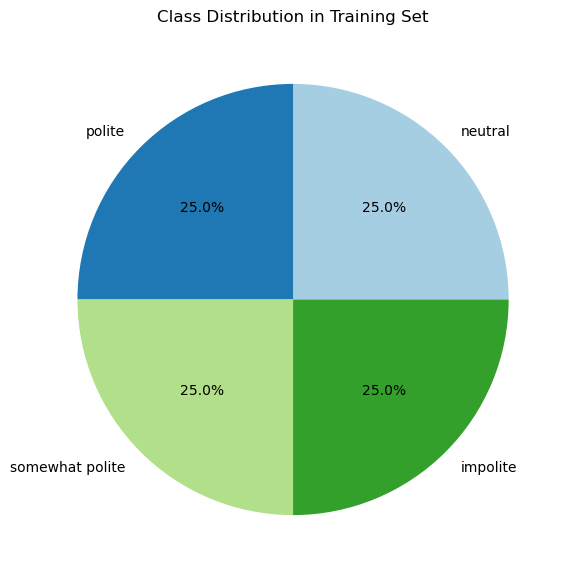

In [8]:
import matplotlib.pyplot as plt

label_counts = traning_set["label"].value_counts()

print("Amount of each class in the training set:")
print(label_counts)

plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", colors=plt.cm.Paired.colors)
plt.title("Class Distribution in Training Set")
plt.show()

##### As we can see, we have a perfectly balanced dataset as each label has 20000 examples.

### **Counts and Length**

##### It is also important to know the characteristics of the documents we are taking into consideration on this task. 

##### Firstly, let's check the Word Count of each document's text.

First Quartile (Q1) for unclean text: 23.0
Third Quartile (Q3) for unclean text: 38.0
First Quartile (Q1) for clean text: 10.0
Third Quartile (Q3) for clean text: 18.0


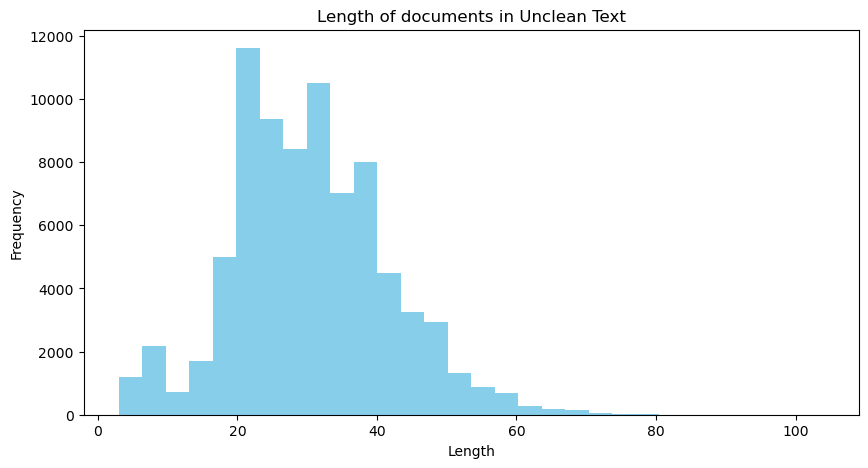

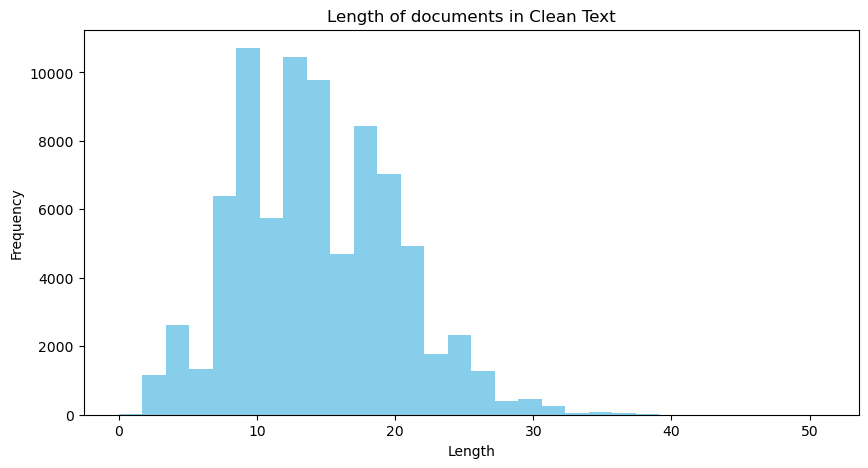

In [9]:
word_count = traning_set["unclean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
plt.hist(word_count, bins=30, color="skyblue")

plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Word Count of documents in Unclean Text")

# Calculate Q1 and Q3
Q1 = word_count.quantile(0.25)
Q3 = word_count.quantile(0.75)

print("First Quartile (Q1) for unclean text:", Q1)
print("Third Quartile (Q3) for unclean text:", Q3)

word_count = traning_set["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
plt.hist(word_count, bins=30, color="skyblue")

plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Word Count of documents in Clean Text")

# Calculate Q1 and Q3
Q1 = word_count.quantile(0.25)
Q3 = word_count.quantile(0.75)

print("First Quartile (Q1) for clean text:", Q1)
print("Third Quartile (Q3) for clean text:", Q3)

##### Our documents have mostly between 23 and 38 words at the unclean text and 10 and 18 words at the clean text. This is expectable of course as we have a stopwords filter included in our text pre-processing pipeline.

##### We can consider our dataset is composed of small text for this problem. This may affect our decisions and performance of certain algorithms further on this work.

##### Now let's proceed with the character count

First Quartile (Q1) for unclean text: 129.0
Third Quartile (Q3) for unclean text: 217.0
First Quartile (Q1) for clean text: 63.0
Third Quartile (Q3) for clean text: 116.0


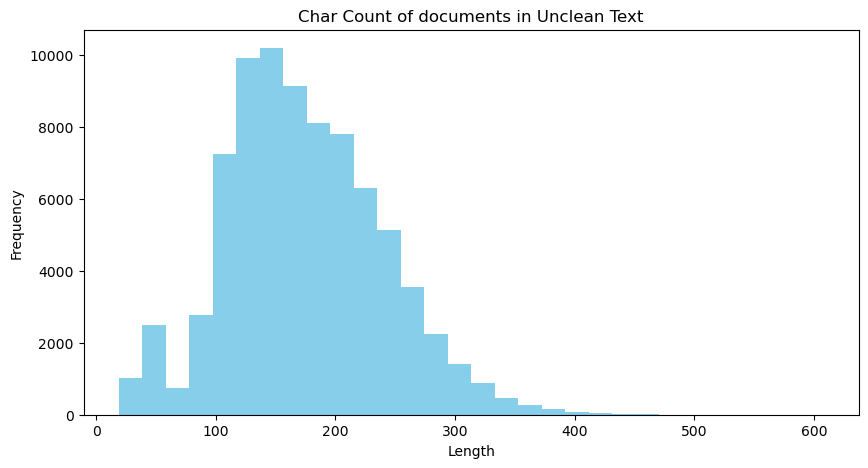

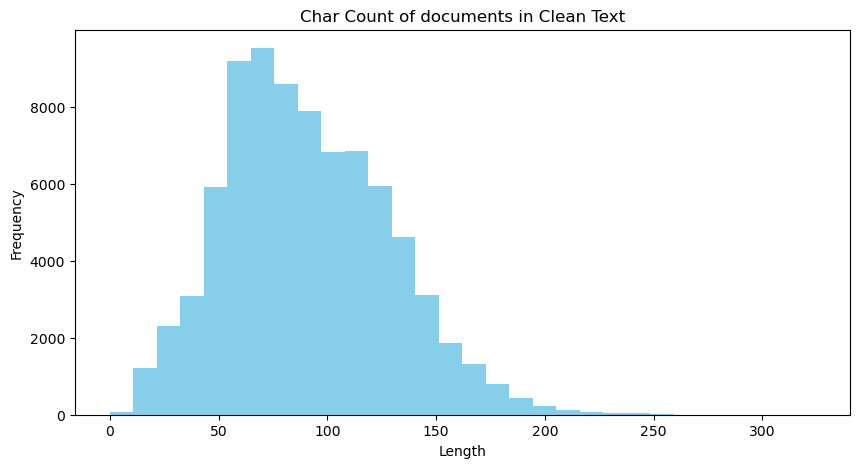

In [12]:
char_count = traning_set["unclean_text"].apply(lambda x: len(x))

plt.figure(figsize=(10, 5))
plt.hist(char_count, bins=30, color="skyblue")

plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Char Count of documents in Unclean Text")

# Calculate Q1 and Q3
Q1 = char_count.quantile(0.25)
Q3 = char_count.quantile(0.75)

print("First Quartile (Q1) for unclean text:", Q1)
print("Third Quartile (Q3) for unclean text:", Q3)

char_count = traning_set["clean_text"].apply(lambda x: len(x))

plt.figure(figsize=(10, 5))
plt.hist(char_count, bins=30, color="skyblue")

plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Char Count of documents in Clean Text")

# Calculate Q1 and Q3
Q1 = char_count.quantile(0.25)
Q3 = char_count.quantile(0.75)

print("First Quartile (Q1) for clean text:", Q1)
print("Third Quartile (Q3) for clean text:", Q3)

##### Now let's proceed to the average length of words and the average sentence length


In [15]:
import numpy as np
from nltk import tokenize

print("Unclean text average sentence length:")
print(np.mean(traning_set['unclean_text'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))))
print("Clean text average sentence length:")
print(np.mean(traning_set['clean_text'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))))
print("Unclean text average word length:")
print(np.mean(traning_set['unclean_text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))))
print("Clean text average word length:")
print(np.mean(traning_set['clean_text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))))


Unclean text average sentence length:
84.82997663690476
Clean text average sentence length:
90.54438180477256
Unclean text average word length:
4.7908009727635275
Clean text average word length:
5.370793926543044


### **TF-IDF**
##### This is a measure that takes into account the discriminative power of the words (repetitions of a word accross documents/text or power of a word to distinguish the document content) from the vocabulary considering all the documents(our texts), by assigning a weight to each of the terms of the vocabulary.
##### **TF** stands for Term Frequency and is the total frequency that a word appears considering all the documents;
##### **DF** stands for Document Frequency and it measures the number of documents that have a certain word. The higher the more frequent is a word accross all the documents (bad thing -> low discriminative power);
##### **IDF** stands for Inverse Document Frequency and the inverse of the DF. Higher means rarer the word is accross all the documents (good thing -> high discriminative power).
##### **TF-IDF** is a measure that is the product of **TF** and **IDF**:
- ##### Highest when t occurs many times within a small number of documents;
- ##### Lower when the term occurs fewer times in a document, or occurs in many documents;
- ##### Lowest when the term occurs in virtually all documents.


##### This measure is extremely useful in exploratory data analysis as we get a proper information about the most important words in a dataset while reducing the importance of common words that may appear in a large set of documents.
##### As we saw before, our documents are usually small, so TF-IDF may not be able to perform too well in differentiating low and high occurences.

/tmp/ipykernel_2852/2234674731.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index, palette="viridis")


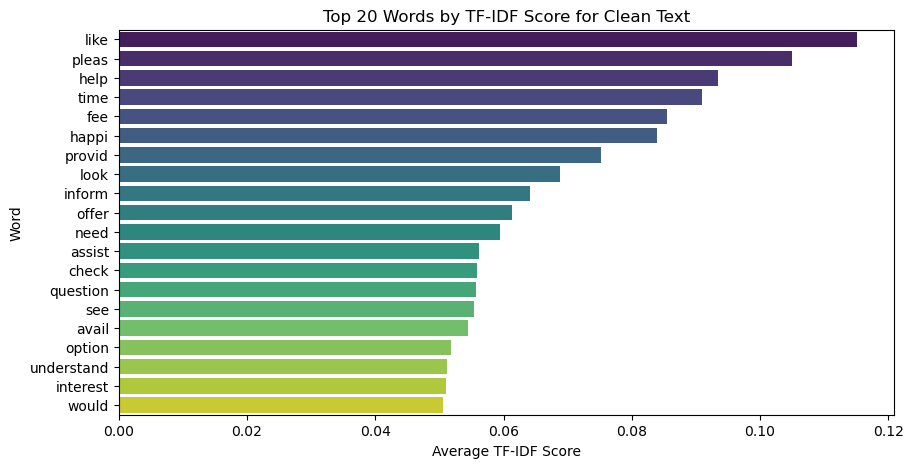

/tmp/ipykernel_2852/2234674731.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index, palette="viridis")


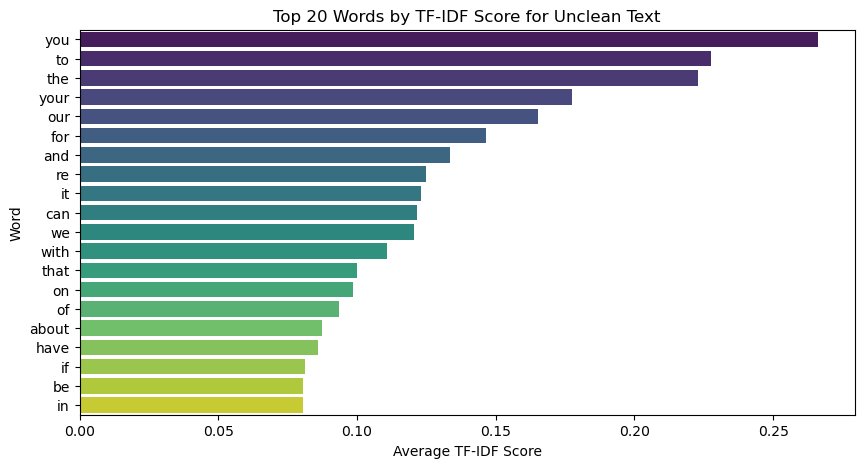

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20)  # Select the top 20 words
tfidf_matrix = tfidf.fit_transform(traning_set["clean_text"])

# Convert TF-IDF scores into a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Get mean TF-IDF scores for each word
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Plot the top TF-IDF words
plt.figure(figsize=(10, 5))
sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index, palette="viridis")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.title("Top 20 Words by TF-IDF Score for Clean Text")
plt.show()

tfidf_matrix = tfidf.fit_transform(traning_set["unclean_text"])

# Convert TF-IDF scores into a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Get mean TF-IDF scores for each word
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index, palette="viridis")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.title("Top 20 Words by TF-IDF Score for Unclean Text")
plt.show()

##### As we can see, at the clean text we can clearly see some words that may have a big impact for our classification task (sentiment analysis) have a high TF-IDF Score, such as like and happy.